# Training & Optimization
This notebook shows the process for training and optimizing a model.

## Data Preprocessing

## Training

In [219]:
import json
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pickle
import tensorflow as tf

import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# Reading the Data

In [193]:
train_size = np.floor(n_days * 0.75)/n_days

# input/output structure
n_features = 2 # for input
n_steps_in = 16
n_steps_out = 4

In [194]:
# load the data by iterating through all files
dirname = "../../!data/pre-loaded/04all_data_16in_4out/"

X = np.empty((0,n_steps_in,n_features))
y = np.empty((0,n_steps_out))
for file in os.listdir(dirname):
    filename = dirname + file
    print(filename)
    if file.endswith(".X"):
        to_open = open(filename, 'rb')
        X = np.concatenate((X, pickle.load(to_open)))
        to_open.close()
    if file.endswith(".y"):
        to_open = open(filename, 'rb')
        y = np.concatenate((y, pickle.load(to_open)))
        to_open.close()

../../!data/pre-loaded/04all_data_16in_4out/all_dates.16.4.15Min.unscaled.y
../../!data/pre-loaded/04all_data_16in_4out/all_dates.16.4.15Min.unscaled.X


In [195]:
# scale each variable independently
scalers = []
for i in range(X.shape[-1]):
    scaler = MinMaxScaler()
    X[:,:,i] = scaler.fit_transform(X[:,:,i].reshape(-1,1)).reshape(X[:,:,i].shape)
    scalers.append(scaler)
y = scalers[0].transform(y.reshape(-1,1)).reshape(y.shape)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=train_size)

# Training & Evaluation

In [197]:
# section-specific imports
from keras.metrics import mean_squared_error
from keras.models import Sequential, load_model, clone_model
from keras.layers import LSTM, Dense

# Hyperparameter Optimization

In [210]:
# objective func to be maximized
def objective(trial):
    model, loss, pred = train_and_evaluate_model(trial, X_train, X_test, y_train, y_test)
    return loss

# study object which optimizes objective func
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12)
beep_completed()

[I 2022-07-14 16:33:57,348] A new study created in memory with name: no-name-3f43c19f-e1a0-4e4b-bce9-8d9f86f17b70


-----begin training
-----epoch #1
939/939 [==============================] - 2s 2ms/step - loss: 0.0124
loss=0.007806370694571352, improvement, best_idx=1, curr_idx=1
[inf, 0.007806370694571352]


[I 2022-07-14 16:34:09,811] Trial 0 finished with value: 0.007018803748530464 and parameters: {'n_neurons': 32, 'n_layers': 1}. Best is trial 0 with value: 0.007018803748530464.


-----final evaluation
0.007018803748530464


In [138]:
# use the best model and run through the data to get a final evaluation
model = build_model(study.best_trial)
model.fit(X_train, y_train, batch_size=datapoints_per_day)

loss, pred = model_eval(model, X_test, y_test, return_pred=True)
loss = np.average(loss)
print(loss)

1122/1122 [==============================] - 31s 26ms/step - loss: 0.0193
0.017651965712067636


In [220]:
filename = f"{n_steps_in}in.{n_steps_out}out.{json.dumps(study.best_params)}"
pickle.dump(model, open(filename, 'wb'))

2022-07-14 16:36:49.414970: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmps4k9d0ai/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmps4k9d0ai/assets


# Visualization

In [139]:
# unscale using the scaler for solar irradiance
true_pred = scalers[0].inverse_transform(pred)
true_y_test = scalers[0].inverse_transform(y_test)

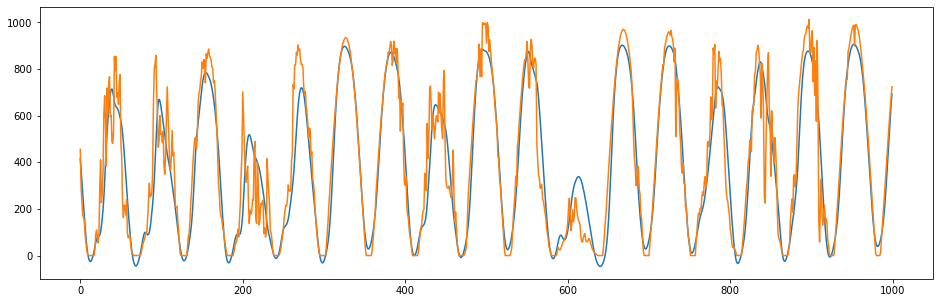

In [180]:
plt.figure(figsize=(16,5))
plot_var = 1000
plt.plot(true_pred[:plot_var,0])
plt.plot(true_y_test[:plot_var,0])

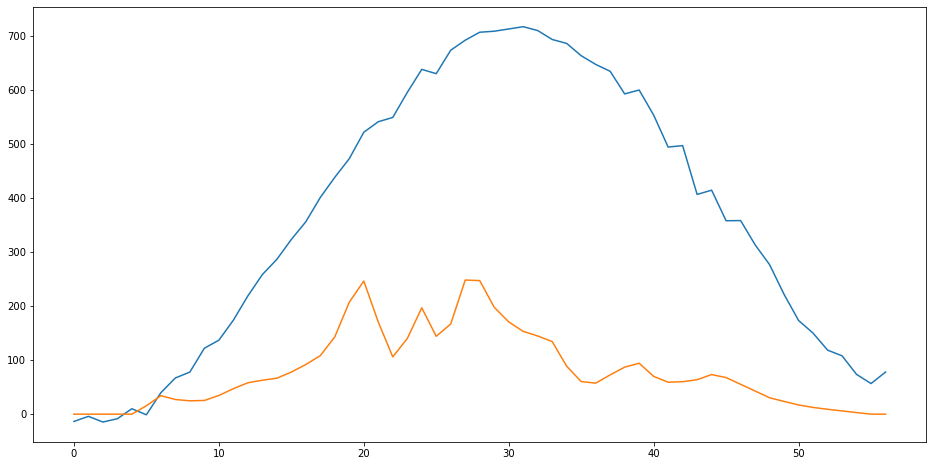

In [184]:
plt.figure(figsize=(16,8))
plot_var = 10*57 + 12
plt.plot(true_pred[plot_var,:])
plt.plot(true_y_test[plot_var,:])

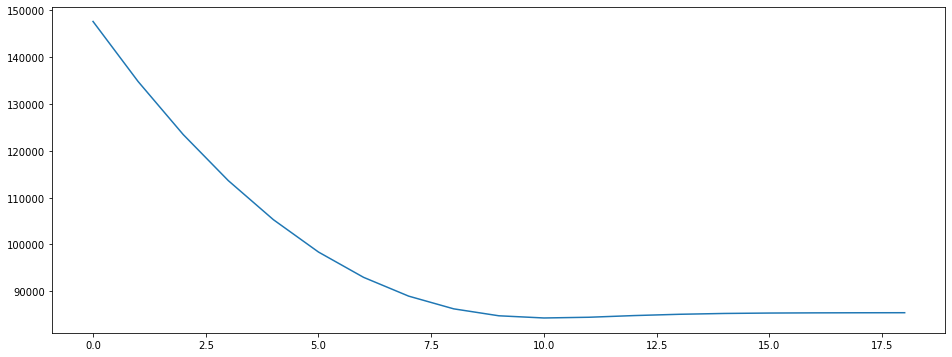

In [148]:
loss_history = [162044.571336178, 147607.44596565652, 134780.23877090827, 123457.13892374793, 113619.47308848653, 105277.15258670824, 98366.799135071, 92963.0316370447, 88950.82737973481, 86233.57735207972, 84753.22173991922, 84286.16873626038, 84440.54232807294, 84799.02049708486, 85073.4634269276, 85250.86506758285, 85337.53184477196, 85378.2458342352, 85399.57257429743, 85408.89439098221]
plt.figure(figsize=(16,6))
plt.plot(loss_history[1:])